In [ ]:
!pip install transformers torch

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

import pickle
import time
import string
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.legacy import data
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH = 'data'

RANDOM_STATE = 1

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


cuda:0


#### Creating dataset from bbc news

In [ ]:
# data = []
# for category in tqdm(categories):
#   summary_path = PATH + 'BBC News Summary/Summaries/' + category
#   article_path = PATH + 'BBC News Summary/News Articles/' + category
#   for filename in tqdm(os.listdir(article_path)):
#     article = ''
#     summary = ''
#     with open(article_path + "/" + filename, encoding='latin1') as f:
#       article = f.read()
#     with open(summary_path + "/" + filename, encoding='latin1') as f:
#       summary = f.read()
#     data.append([article, summary, category])
# print(data[:3])

# new_data = []
# for row in data:
#   article = row[0].splitlines()
#   body = " ".join([sent for sent in article[2:] if sent != ""])
#   print(body)
#   break
#   new_data.append([article[0], body, row[1], row[2]])

# df = pd.DataFrame(new_data, columns = ['Title', 'Body', 'Summary', 'Category'])
# df.to_csv(PATH + 'BBC News Summary/bbc_news_dataset.csv', index=False, header=True)

# Loading and processing dataset

### Load raw dataset

In [ ]:
raw_df = pd.read_csv(PATH + '/bbc_news_dataset.csv')

### Pre-process text

In [ ]:
MAX_SEQ_LEN = 200

def preprocess_text(text):
  text = text.split()
  text = ' '.join(text[:MAX_SEQ_LEN])
  text = text.lower()
  return text

In [ ]:
raw_df['Title'] = raw_df['Title'].apply(lambda x: preprocess_text(x))
raw_df['Body'] = raw_df['Body'].apply(lambda x: preprocess_text(x))
raw_df['Summary'] = raw_df['Summary'].apply(lambda x: preprocess_text(x))

### Prepare columns for concatenated texts and integer labels

In [ ]:
labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
df = pd.DataFrame(columns=['label', 'titlebody'])
df['label'] = raw_df['Category'].apply(lambda x: labels.index(x))
df['titlebody'] = raw_df['Title'] + ". " + raw_df['Body']

In [ ]:
df.info()

### Split dataset into train, valid, test

In [ ]:
df_business = df[df['label'] == 0]
df_entertainment = df[df['label'] == 1]
df_politics = df[df['label'] == 2]
df_sport = df[df['label'] == 3]
df_tech = df[df['label'] == 4]

# Train-valid-test split 8:1:1

df_business_train, df_business_rem = train_test_split(df_business, train_size=0.8, random_state=RANDOM_STATE)
df_entertainment_train, df_entertainment_rem = train_test_split(df_entertainment, train_size=0.8, random_state=RANDOM_STATE)
df_politics_train, df_politics_rem = train_test_split(df_politics, train_size=0.8, random_state=RANDOM_STATE)
df_sport_train, df_sport_rem = train_test_split(df_sport, train_size=0.8, random_state=RANDOM_STATE)
df_tech_train, df_tech_rem = train_test_split(df_tech, train_size=0.8, random_state=RANDOM_STATE)

df_business_valid, df_business_test = train_test_split(df_business_rem, train_size=0.5, random_state=RANDOM_STATE)
df_entertainment_valid, df_entertainment_test = train_test_split(df_entertainment_rem, train_size=0.5, random_state=RANDOM_STATE)
df_politics_valid, df_politics_test = train_test_split(df_politics_rem, train_size=0.5, random_state=RANDOM_STATE)
df_sport_valid, df_sport_test = train_test_split(df_sport_rem, train_size=0.5, random_state=RANDOM_STATE)
df_tech_valid, df_tech_test = train_test_split(df_tech_rem, train_size=0.5, random_state=RANDOM_STATE)


df_train = pd.concat([df_business_train, df_entertainment_train, df_politics_train, df_sport_train, df_tech_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_business_valid, df_entertainment_valid, df_politics_valid, df_sport_valid, df_tech_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_business_test, df_entertainment_test, df_politics_test, df_sport_test, df_tech_test], ignore_index=True, sort=False)

# Save to file
df_train.to_csv(PATH + '/train.csv', index=False)
df_valid.to_csv(PATH + '/valid.csv', index=False)
df_test.to_csv(PATH + '/test.csv', index=False)

# Fine-tuning a pre-trained Bert model

Uses “bert-base-uncased” version of BERT, which is pre-trained on lower-cased English text

(with 12-layer, 768-hidden, 12-heads, 110M parameters)

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper: https://arxiv.org/pdf/1810.04805.pdf):

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameters
BATCH_SIZE = 16
MAX_SEQ_LEN = 200
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = data.Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = data.Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('titlebody', text_field)]

# TabularDataset
train, valid, test = data.TabularDataset.splits(path=PATH, train='train.csv', validation='valid.csv', test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = data.BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.titlebody), device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = data.BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.titlebody), device=device, train=True, sort=True, sort_within_batch=True)
test_iter = data.Iterator(test, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
class BertModel(nn.Module):
    def __init__(self):
        super(BertModel, self).__init__()
        self.encoder = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]
        return loss, text_fea

### Training

In [ ]:
def save_model(path, model, valid_loss):
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, path)

def load_model(path, model):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)

def load_metrics(path):
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model, optimizer, train_set=train_iter, valid_set=valid_iter,
          num_epochs=5, eval_every = len(train_iter) // 2,
          file_path = PATH, best_valid_loss = float("Inf")):
    
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # Training loop
    model.train()
    for epoch in tqdm(range(num_epochs)):
      # Perform one full pass over the train set
      print('======= Epoch [{}/{}] ======='.format(epoch+1, num_epochs))

      for (labels, titlebody), _ in tqdm(train_set):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)
        titlebody = titlebody.type(torch.LongTensor)  
        titlebody = titlebody.to(device)
        output = model(titlebody, labels)
        loss, _ = output

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running values
        running_loss += loss.item()
        global_step += 1

        # Evaluation on valid set
        if global_step % eval_every == 0:
          model.eval()
          with torch.no_grad():
            # Validation loop
            for (labels, titlebody), _ in valid_set:
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                titlebody = titlebody.type(torch.LongTensor)  
                titlebody = titlebody.to(device)
                output = model(titlebody, labels)
                loss, _ = output
                
                valid_running_loss += loss.item()

          # Compute metrics
          average_train_loss = running_loss / eval_every
          average_valid_loss = valid_running_loss / len(valid_set)
          train_loss_list.append(average_train_loss)
          valid_loss_list.append(average_valid_loss)
          global_steps_list.append(global_step)

          # Reset running values
          running_loss = 0.0                
          valid_running_loss = 0.0
          model.train()

          # Log progress
          print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                .format(epoch+1, num_epochs, global_step, num_epochs*len(train_set),
                        average_train_loss, average_valid_loss))
          
          # Save Model
          if best_valid_loss > average_valid_loss:
              best_valid_loss = average_valid_loss
              save_model(file_path + '/model.pt', model, best_valid_loss)
              save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Training complete!')

In [ ]:
model = BertModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer, num_epochs=4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======= Epoch [1/4] =======


Epoch [1/4], Step [56/448], Train Loss: 1.1056, Valid Loss: 0.6417
Epoch [1/4], Step [112/448], Train Loss: 0.3167, Valid Loss: 0.2013

======= Epoch [2/4] =======


Epoch [2/4], Step [168/448], Train Loss: 0.1762, Valid Loss: 0.1827
Epoch [2/4], Step [224/448], Train Loss: 0.0675, Valid Loss: 0.1717

======= Epoch [3/4] =======


Epoch [3/4], Step [280/448], Train Loss: 0.0722, Valid Loss: 0.1810
Epoch [3/4], Step [336/448], Train Loss: 0.0633, Valid Loss: 0.1800

======= Epoch [4/4] =======


Epoch [4/4], Step [392/448], Train Loss: 0.0508, Valid Loss: 0.1444
Epoch [4/4], Step [448/448], Train Loss: 0.0191, Valid Loss: 0.1257


Training complete!


### Plot Training and Validation Loss

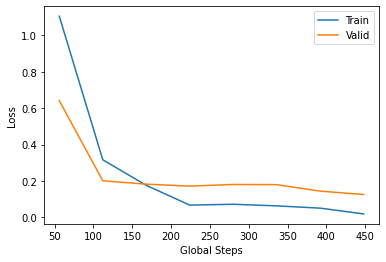

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(PATH + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Evaluation

In [ ]:
def evaluate(model, test_set=test_iter):
  y_pred = []
  y_true = []
  model.eval()
  with torch.no_grad():
    for (labels, titlebody), _ in tqdm(test_set):
        labels = labels.type(torch.LongTensor)           
        labels = labels.to(device)
        titlebody = titlebody.type(torch.LongTensor)  
        titlebody = titlebody.to(device)
        output = model(titlebody, labels)
        _, output = output
        y_pred.extend(torch.argmax(output, 1).tolist())
        y_true.extend(labels.tolist())

  print('Classification Report:')
  print(classification_report(y_true, y_pred, labels=[0,1,2,3,4], digits=4))

  cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix')

  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')

  ax.xaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech'])
  ax.yaxis.set_ticklabels(['business', 'entertainment', 'politics', 'sport', 'tech'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Classification Report:
              precision    recall  f1-score   support

           0     0.9796    0.9412    0.9600        51
           1     0.9750    1.0000    0.9873        39
           2     1.0000    1.0000    1.0000        42
           3     1.0000    1.0000    1.0000        52
           4     0.9524    0.9756    0.9639        41

    accuracy                         0.9822       225
   macro avg     0.9814    0.9834    0.9822       225
weighted avg     0.9824    0.9822    0.9822       225



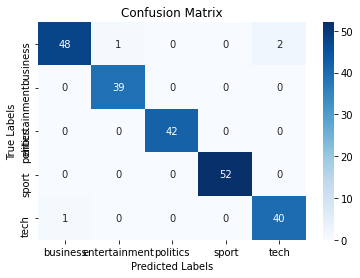

In [ ]:
bert_model = BertModel().to(device)
load_model(PATH + '/model.pt', bert_model)
evaluate(bert_model, test_iter)